#merging all the saperate dataset files and taking only data that is significant in classifying a network into Benign or Threat to form a dataset

In [ ]:
import glob
dirpath = "C:/Work/IFT520/Project/archive/*csv"
csvpath = glob.glob(dirpath)
csvpath

[]

In [ ]:
import pandas as pd
dataset = pd.DataFrame()
for files in csvpath:
    data = pd.read_csv(files)
    data = data[['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Label']]
    dataset = pd.concat([dataset,data],axis=0)

In [ ]:
dataset.to_csv('./Dataset/dataset_eight_columns.csv')

In [ ]:
import pandas as pd
dataset = pd.read_csv('./Dataset/dataset_eight_columns.csv')

In [ ]:
dataset

,0,0.1,112641719,3,0.2,Benign
0,0,0,112641466.0,3,0,Benign
1,0,0,112638623.0,3,0,Benign
2,22,6,6453966.0,15,10,Benign
3,22,6,8804066.0,14,11,Benign
4,22,6,6989341.0,16,12,Benign
...,...,...,...,...,...,...
1048569,80,6,10156986.0,5,5,Benign
1048570,80,6,117.0,2,0,Benign
1048571,80,6,5095331.0,3,1,Benign
1048572,80,6,5235511.0,3,1,Benign


#Using standard scaler to normalize dataset values in the range [0, 1], deep learning models tend to be more accurate with normalized data.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(dataset.iloc[:,:5])

In [ ]:
scaled_dataset.shape

(1048574, 5)

In [ ]:
import numpy as np
labels = dataset.iloc[:,5:]
np.unique(labels)

array(['Benign', 'FTP-BruteForce', 'SSH-Bruteforce'], dtype=object)

#Encoding labels which are in string data to numerical using LabelEncoder that converts string to integer since the model can only work with numerical values.

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
encoded_labels

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
np.unique(encoded_labels)

array([0, 1, 2])

#Splitting the dataset into train and test datasets. The chosen split is 80% data for training and 20% data for testing.

In [ ]:
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
tf.random.set_seed(42)
X_train, X_test, y_train, y_test = train_test_split(scaled_dataset, encoded_labels, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((838859, 5), (209715, 5), (838859,), (209715,))

# Obtaining Predictions using naive bayes classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
naive_bayes = GaussianNB()
naive_bayes_history = naive_bayes.fit(X_train, y_train)
predictions = naive_bayes.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

In [ ]:
accuracy*100

91.02782347471569

# Obtaining predictions using the random forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_history = random_forest.fit(X_train, y_train)
rf_predictions = random_forest.predict(X_test)
accuracy_random_forest = accuracy_score(y_test, rf_predictions)

In [ ]:
accuracy_random_forest*100

99.99570846148345

#Obtaining predictions using K-Nearest Neighbour classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knearest_classifier = KNeighborsClassifier(n_neighbors=3)
knearest_history = knearest_classifier.fit(X_train, y_train)
knn_predictions = knearest_classifier.predict(X_test)
accuracy_knearest = accuracy_score(y_test, knn_predictions)

In [ ]:
accuracy_knearest*100

99.9961852990964

#Obtaining predictions using adaboost with decision tree as base classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
base_classifier = DecisionTreeClassifier(max_depth=3)
adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=100, random_state=42)
adaboost_history = adaboost_classifier.fit(X_train, y_train)
adaboost_predictions = adaboost_classifier.predict(X_test)
accuracy_adaboost = accuracy_score(y_test, adaboost_predictions)

In [ ]:
accuracy_adaboost*100

99.9961852990964

#Obtaining predictions using Multi Layer Perceptron (MLP)

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_history = mlp_classifier.fit(X_train, y_train)
mlp_predictions = mlp_classifier.predict(X_test)
accuracy_mlp = accuracy_score(y_test, mlp_predictions)

In [ ]:
accuracy_mlp*100

91.00255108122929

#fitting the data on a custom sequential model with Dense layers having multiple nodes each using adam optimizer with relu and softmax activation functions.
#batch size 32 and training for 5 epochs.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report

model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
sequential_history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)
sequential_predictions = model.predict(X_test)
sequential_predictions = np.argmax(sequential_predictions, axis=1)
accuracy_sequential = accuracy_score(y_test, sequential_predictions)

Epoch 1/5
20972/20972 [==============================] - 96s 4ms/step - loss: 0.2564 - accuracy: 0.9044 - val_loss: 0.1855 - val_accuracy: 0.9088
Epoch 2/5
20972/20972 [==============================] - 84s 4ms/step - loss: 0.1946 - accuracy: 0.9094 - val_loss: 0.1826 - val_accuracy: 0.9086
Epoch 3/5
20972/20972 [==============================] - 82s 4ms/step - loss: 0.1821 - accuracy: 0.9094 - val_loss: 0.1818 - val_accuracy: 0.9086
Epoch 4/5
20972/20972 [==============================] - 85s 4ms/step - loss: 0.1815 - accuracy: 0.9095 - val_loss: 0.1836 - val_accuracy: 0.9086
Epoch 5/5
6554/6554 [==============================] - 14s 2ms/step


In [ ]:
accuracy_sequential

0.908780964642491

#As we can see from the training of this model the model reaches saturation on the very first epoch as the acuracy does not increse any further. Below is analysis about choosing the right learning rate.

In [ ]:
def lr_schedule(epoch):
    initial_lr = 0.01
    decay = 0.9
    lr = initial_lr * decay ** epoch
    return lr

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import LearningRateScheduler

model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=[LearningRateScheduler(lr_schedule)]
)

sequential_predictions = model.predict(X_test)
sequential_predictions = np.argmax(sequential_predictions, axis=1)
accuracy_sequential = accuracy_score(y_test, sequential_predictions)

Epoch 1/5
20972/20972 [==============================] - 86s 4ms/step - loss: 0.2550 - accuracy: 0.9060 - val_loss: 0.1853 - val_accuracy: 0.9084 - lr: 0.0100
Epoch 2/5
20972/20972 [==============================] - 93s 4ms/step - loss: 0.1863 - accuracy: 0.9087 - val_loss: 0.1846 - val_accuracy: 0.9085 - lr: 0.0090
Epoch 3/5
20972/20972 [==============================] - 94s 4ms/step - loss: 0.2338 - accuracy: 0.9089 - val_loss: 0.1830 - val_accuracy: 0.9085 - lr: 0.0081
Epoch 4/5
20972/20972 [==============================] - 95s 5ms/step - loss: 0.1831 - accuracy: 0.9092 - val_loss: 0.1843 - val_accuracy: 0.9084 - lr: 0.0073
Epoch 5/5
6554/6554 [==============================] - 13s 2ms/step


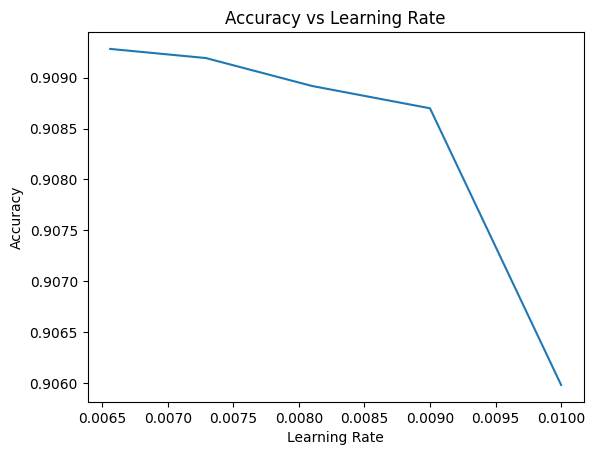

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['lr'], history.history['accuracy'])
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate')
plt.show()

#It is visible from the graph that the accuracy increases where the learning rate is approximately 0.0075, otherwise it is decreasing, the model below is trained by using the learning rate at 0.0075 to check if the model improves.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=3, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.0075), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
)

sequential_predictions = model.predict(X_test)
sequential_predictions = np.argmax(sequential_predictions, axis=1)
accuracy_sequential = accuracy_score(y_test, sequential_predictions)

Epoch 1/5
20972/20972 [==============================] - 85s 4ms/step - loss: 0.2619 - accuracy: 0.9066 - val_loss: 0.2038 - val_accuracy: 0.9051
Epoch 2/5
20972/20972 [==============================] - 96s 5ms/step - loss: 0.1963 - accuracy: 0.9089 - val_loss: 0.1835 - val_accuracy: 0.9086
Epoch 3/5
20972/20972 [==============================] - 84s 4ms/step - loss: 0.1846 - accuracy: 0.9089 - val_loss: 0.1837 - val_accuracy: 0.9085
Epoch 4/5
20972/20972 [==============================] - 85s 4ms/step - loss: 0.1837 - accuracy: 0.9091 - val_loss: 0.1973 - val_accuracy: 0.9028
Epoch 5/5
6554/6554 [==============================] - 13s 2ms/step


#The learning rate did not improve accuracy significantly so now, we will try to improve the model by making it more complex and adding more dense layers with higher number of hidden nodes.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=3, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.0075), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
)

sequential_predictions = model.predict(X_test)
sequential_predictions = np.argmax(sequential_predictions, axis=1)
accuracy_sequential = accuracy_score(y_test, sequential_predictions)

Epoch 1/5
20972/20972 [==============================] - 100s 5ms/step - loss: 0.3880 - accuracy: 0.8051 - val_loss: 0.4671 - val_accuracy: 0.7455
Epoch 2/5
20972/20972 [==============================] - 97s 5ms/step - loss: 0.5742 - accuracy: 0.6632 - val_loss: 0.5695 - val_accuracy: 0.6671
Epoch 3/5
20972/20972 [==============================] - 107s 5ms/step - loss: 0.5650 - accuracy: 0.6793 - val_loss: 0.5558 - val_accuracy: 0.6771
Epoch 4/5
20972/20972 [==============================] - 109s 5ms/step - loss: 0.6028 - accuracy: 0.6462 - val_loss: 0.5567 - val_accuracy: 0.6712
Epoch 5/5
6554/6554 [==============================] - 13s 2ms/step


#Adding complexity did not improve results rather it made the results even worse, now let us try and reduce the complexity to check if that helps.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=3, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.0075), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
)

sequential_predictions = model.predict(X_test)
sequential_predictions = np.argmax(sequential_predictions, axis=1)
accuracy_sequential = accuracy_score(y_test, sequential_predictions)

Epoch 1/5
20972/20972 [==============================] - 98s 5ms/step - loss: 0.3035 - accuracy: 0.9062 - val_loss: 0.1930 - val_accuracy: 0.9071
Epoch 2/5
20972/20972 [==============================] - 94s 4ms/step - loss: 0.1846 - accuracy: 0.9090 - val_loss: 0.1844 - val_accuracy: 0.9085
Epoch 3/5
20972/20972 [==============================] - 95s 5ms/step - loss: 0.2185 - accuracy: 0.9091 - val_loss: 0.1832 - val_accuracy: 0.9085
Epoch 4/5
20972/20972 [==============================] - 85s 4ms/step - loss: 0.1838 - accuracy: 0.9090 - val_loss: 0.1844 - val_accuracy: 0.9084
Epoch 5/5
6554/6554 [==============================] - 13s 2ms/step


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

model = Sequential()
model.add(Dense(units=2, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=4, activation='relu'))
model.add(Dense(units=3, activation='softmax'))
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

sequential_history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
)

sequential_predictions = model.predict(X_test)
sequential_predictions = np.argmax(sequential_predictions, axis=1)
accuracy_sequential = accuracy_score(y_test, sequential_predictions)

Epoch 1/5
20972/20972 [==============================] - 85s 4ms/step - loss: 0.4310 - accuracy: 0.7687 - val_loss: 0.3701 - val_accuracy: 0.7877
Epoch 2/5
20972/20972 [==============================] - 84s 4ms/step - loss: 0.3575 - accuracy: 0.8009 - val_loss: 0.2273 - val_accuracy: 0.9098
Epoch 3/5
20972/20972 [==============================] - 95s 5ms/step - loss: 0.1862 - accuracy: 0.9105 - val_loss: 0.1798 - val_accuracy: 0.9097
Epoch 4/5
20972/20972 [==============================] - 87s 4ms/step - loss: 0.1929 - accuracy: 0.9058 - val_loss: 0.3879 - val_accuracy: 0.8443
Epoch 5/5
6554/6554 [==============================] - 13s 2ms/step


#We tried to improve the sequential model by finding out and using the optimal learning rate(0.0075), introducing dropout layer to reduce overfitting, using batch normalization to increase randomness in training data, making model more complex by increasing number of hidden units and also tried by decreasing the number of hidden units but by far the highest accuracy that can be achived by all the configuration is ~ 90-91% which falls significantly behind other multi-label classifiers that we implemented during this project.

In [ ]:
accuracy_sequential

0.9099492167942207

In [ ]:
#Accuracy of different models
print("Accuracy of Naive-Bayes classifier: ", accuracy)
print("Accuracy of Random Forest classifier: ", accuracy_random_forest)
print("Accuracy of K-Nearest Neighbour classifier: ", accuracy_knearest)
print("Accuracy of Adaboost classifier: ", accuracy_adaboost)
print("Accuracy of Multi-Layer Perceptron classifier: ", accuracy_mlp)
print("Accuracy of custom sequential classifier: ", accuracy_sequential)

Accuracy of Naive-Bayes classifier:  0.9102782347471569
Accuracy of Random Forest classifier:  0.9999570846148345
Accuracy of K-Nearest Neighbour classifier:  0.999961852990964
Accuracy of Adaboost classifier:  0.999961852990964
Accuracy of Multi-Layer Perceptron classifier:  0.9100255108122929
Accuracy of custom sequential classifier:  0.9099492167942207


In [ ]:
from sklearn.metrics import confusion_matrix
cm_sequential = confusion_matrix(y_test, sequential_predictions, labels=[0,1])
print("custom sequential model")
print("True Poitives: ", cm_sequential[0][0])
print("False Positives: ", cm_sequential[0][1])
print("False Negative: ", cm_sequential[1][0])
print("True Negative: ", cm_sequential[1][1])

custom sequential model
True Poitives:  133323
False Positives:  40
False Negative:  0
True Negative:  38762


In [ ]:
from sklearn.metrics import confusion_matrix
cm_mlp = confusion_matrix(y_test, mlp_predictions, labels=[0,1])
print("MultiLayerPerceptron")
print("True Poitives: ", cm_mlp[0][0])
print("False Positives: ", cm_mlp[0][1])
print("False Negative: ", cm_mlp[1][0])
print("True Negative: ", cm_mlp[1][1])

MultiLayerPerceptron
True Poitives:  133340
False Positives:  29
False Negative:  0
True Negative:  38762


In [ ]:
cm_adaboost = confusion_matrix(y_test, adaboost_predictions, labels=[0,1])
cm_adaboost = confusion_matrix(y_test, adaboost_predictions, labels=[0,1])
print("adaboost")
print("True Poitives: ", cm_adaboost[0][0])
print("False Positives: ", cm_adaboost[0][1])
print("False Negative: ", cm_adaboost[1][0])
print("True Negative: ", cm_adaboost[1][1])

adaboost
True Poitives:  133366
False Positives:  1
False Negative:  0
True Negative:  38762


In [ ]:
cm_Knearest = confusion_matrix(y_test, knn_predictions, labels=[0,1])
print("K-Nearest Neighbour")
print("True Poitives: ", cm_Knearest[0][0])
print("False Positives: ", cm_Knearest[0][1])
print("False Negative: ", cm_Knearest[1][0])
print("True Negative: ", cm_Knearest[1][1])

K-Nearest Neighbour
True Poitives:  133366
False Positives:  1
False Negative:  0
True Negative:  38762


In [ ]:
cm_randomforest = confusion_matrix(y_test, rf_predictions, labels=[0,1])
print("Random Forest")
print("True Poitives: ", cm_randomforest[0][0])
print("False Positives: ", cm_randomforest[0][1])
print("False Negative: ", cm_randomforest[1][0])
print("True Negative: ", cm_randomforest[1][1])

Random Forest
True Poitives:  133367
False Positives:  1
False Negative:  0
True Negative:  38762


In [ ]:
cm_naivebayes = confusion_matrix(y_test, predictions, labels=[0,1])
print("Naive-bayes")
print("True Poitives: ", cm_naivebayes[0][0])
print("False Positives: ", cm_naivebayes[0][1])
print("False Negative: ", cm_naivebayes[1][0])
print("True Negative: ", cm_naivebayes[1][1])

Naive-bayes
True Poitives:  133324
False Positives:  29
False Negative:  0
True Negative:  38762
